In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tables, math, os, sys, scipy
import healpy as hp
import matplotlib.pylab as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
sys.path.append('../')
from core.tools import *
from scipy.interpolate import splrep, splev

from core.tools import _trans
from core.progressbar.progressbar import ProgressBar 

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Generate subclasses required by the analysis
effective area, energy smearing, background/signal descripton etc..

In [4]:
from core.analysis_tools.public_pdfs import *
from core.analysis_tools.amtospheric_background import *
from core.analysis_tools.analysis import KRAgammaAnalysis
from core.analysis_tools.signal_pdfs import SignalSpectrumKRAgamma

In [5]:
effective_areas = EffectiveAreas()
energy_smearing = TrueEnergy2ReconstructedEnergySmearing(
    mc_path='/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
signal_model = SignalSpectrumKRAgamma()

In [6]:
atm_bckg = AtmosphericBackground()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


# Define a binning scheme for this analysis

In [7]:
sindec_bins = np.linspace(-1,1,70)
ra_bins = np.linspace(0, np.pi*2, num=61)
log_ereco_bins = np.arange(2,7.1,0.2)
norms = 10**np.arange(-3.,1.,0.05)

In [8]:
kra_ana = KRAgammaAnalysis(sindec_bins, ra_bins, log_ereco_bins,
                          energy_smearing=energy_smearing, 
                          atm_bckg=atm_bckg, effective_areas=effective_areas,
                          livetime=6., signal_model=signal_model ,norms=norms)

# Show the KRA$\gamma$ flux

[==========================================================] 100% ELT 0h:03m:46s


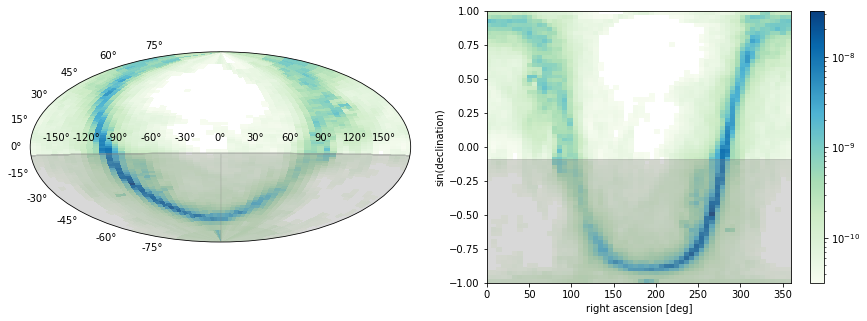

In [9]:
fig = plt.figure(figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0], projection="hammer")
ax2 = fig.add_subplot(spec[1])

lon, lat = _trans(kra_ana.ra_bins,np.arcsin(kra_ana.sindec_bins))

skymap_int = kra_ana.signal_model._generate_KRAgamma_skymap_integrated(kra_ana.ra_mids,
                                                              kra_ana.sindec_mids,
                                                              kra_ana._etrue_mids,
                                                              kra_ana._etrue_bin_width)

mask = skymap_int/skymap_int.max() < 1e-3
skymap_int[mask] = 0



ax.pcolormesh(lon,lat, skymap_int.T, norm=LogNorm(), cmap='GnBu')
ax.fill_between(np.rad2deg(kra_ana.ra_bins), -np.pi/2*np.ones_like(kra_ana.ra_bins), 
                np.ones_like(kra_ana.ra_bins)*np.deg2rad(-5.),
                color='grey', alpha=0.3)



p=ax2.pcolormesh(np.rad2deg(kra_ana.ra_bins),kra_ana.sindec_bins, skymap_int.T, 
                 norm=LogNorm(), cmap='GnBu')
ax2.fill_between(np.rad2deg(kra_ana.ra_bins), -np.ones_like(kra_ana.ra_bins), 
                 np.ones_like(kra_ana.ra_bins)*np.sin(np.deg2rad(-5.)),
                color='grey', alpha=0.3)

ax2.set_xlabel('right ascension [deg]')
ax2.set_ylabel('sin(declination)')



fig.colorbar(p, ax=ax2)

# Show the bckg rate expectation values integrated over the whole sky

[==========================================================] 100% ELT 0h:03m:44s


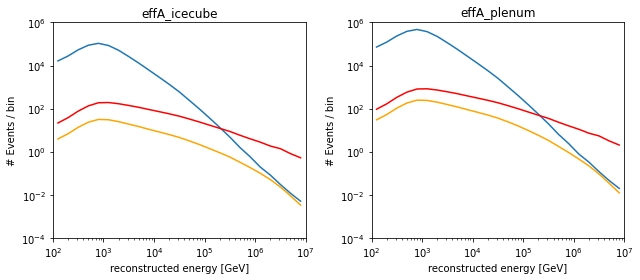

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = kra_ana._generate_background_expectation('numu_total', astro_bckg=False)
d_astro = kra_ana._generate_background_expectation(atm_keys=[], astro_bckg=True)
d_sig = kra_ana._generate_signal_expectation(norm=1, force_update=False)
for k,exp_key in enumerate(d_bckg.keys()):

    
    ax =axes[k]
    ax.set_title(exp_key)
    
    db = d_bckg[exp_key]
    da = d_astro[exp_key]
    ds = d_sig[exp_key][0]
   
    ax.plot(kra_ana.ereco_mids, np.sum(db,axis=(1,2)))
    ax.plot(kra_ana.ereco_mids, np.sum(da,axis=(1,2)), color='red')
    ax.plot(kra_ana.ereco_mids, np.sum(ds,axis=(1,2)), color='orange')
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')


    
fig.tight_layout()


# Now show the event rates in the bin with the largest galactic flux

In [11]:
skymap_int = signal_model._generate_KRAgamma_skymap_integrated(kra_ana.ra_mids,
                                                              kra_ana.sindec_mids,
                                                              kra_ana._etrue_mids,
                                                              kra_ana._etrue_bin_width)

In [12]:
ind_max0,ind_max1 = np.where(skymap_int == np.max(skymap_int))

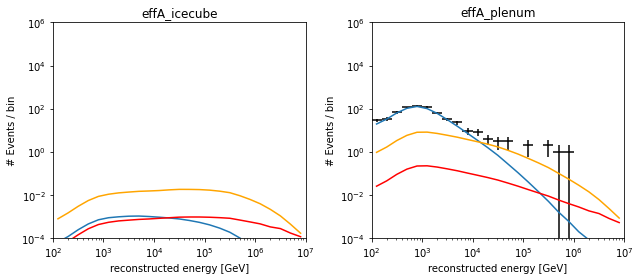

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = kra_ana._generate_background_expectation('numu_total', astro_bckg=False)
d_astro = kra_ana._generate_background_expectation(atm_keys=[], astro_bckg=True)
d_sig = kra_ana._generate_signal_expectation(norm=1)

lambda_b_tot = kra_ana._generate_background_expectation('numu_total', astro_bckg=True)
for exp_key, lb_tot in lambda_b_tot.items():
    lb_tot += d_sig[exp_key][0]

experimental_data = kra_ana.generate_background_data(lambda_b=lambda_b_tot, 
                                                     n_trials=1)
for k,exp_key in enumerate(d_bckg.keys()):

    
    ax =axes[k]
    ax.set_title(exp_key)
    
    db = d_bckg[exp_key]
    da = d_astro[exp_key]
    ds = d_sig[exp_key][0]
   
    
    if k==0:
        ax.plot(kra_ana.ereco_mids, db[:,ind_max0, ind_max1] , label=r'Atm. $\nu_{\mu}$')
        ax.plot(kra_ana.ereco_mids, da[:,ind_max0, ind_max1], color='red', label=r'Extragal. $\nu_{\mu}$')
        ax.plot(kra_ana.ereco_mids, ds[:,ind_max0, ind_max1], color='orange', label=r'Gal. $\nu_{\mu}$')
    else:
        ax.plot(kra_ana.ereco_mids, db[:,ind_max0, ind_max1] )
        ax.plot(kra_ana.ereco_mids, da[:,ind_max0, ind_max1], color='red')
        ax.plot(kra_ana.ereco_mids, ds[:,ind_max0, ind_max1], color='orange')
        
    
    xerrminus = kra_ana.ereco_mids-kra_ana.ereco_bins[:-1]
    xerrplus = kra_ana.ereco_bins[1:] - kra_ana.ereco_mids
    ax.errorbar(kra_ana.ereco_mids, experimental_data[exp_key][0,:,ind_max0, ind_max1][0],
               yerr=np.sqrt(experimental_data[exp_key][0,:,ind_max0, ind_max1])[0],
                xerr=[xerrminus,xerrplus],
                color='black', ls='None')
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')
    
fig.tight_layout()

# And now the event rates in the northern hemisphere only

In [14]:
mask_north = np.arcsin(kra_ana._yy_sdec) >= np.deg2rad(-5.)

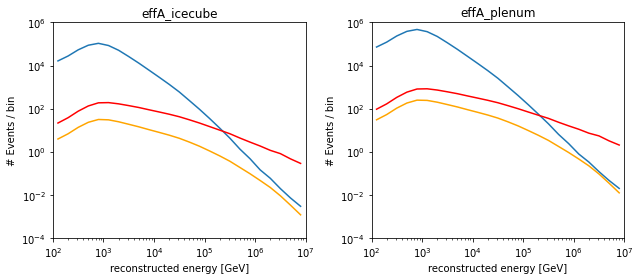

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = kra_ana._generate_background_expectation('numu_total', astro_bckg=False)
d_astro = kra_ana._generate_background_expectation(atm_keys=[], astro_bckg=True)
d_sig = kra_ana._generate_signal_expectation(norm=1)
for k,exp_key in enumerate(d_bckg.keys()):

    
    ax =axes[k]
    ax.set_title(exp_key)
    
    db = d_bckg[exp_key]
    da = d_astro[exp_key]
    ds = d_sig[exp_key][0]
    if 'icecube' in exp_key:
        for i,di in enumerate(db):
            db[i][~mask_north] = 0
            da[i][~mask_north] = 0
            ds[i][~mask_north] = 0
   
    ax.plot(kra_ana.ereco_mids, np.sum(db,axis=(1,2)))
    ax.plot(kra_ana.ereco_mids, np.sum(da,axis=(1,2)), color='red')
    ax.plot(kra_ana.ereco_mids, np.sum(ds,axis=(1,2)), color='orange')
    
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')
fig.tight_layout()

# Generate some background trials

Use only the northern hemisphere for IceCube to have a fair comparison
to current results

In [16]:
mask_north = np.arcsin(kra_ana._yy_sdec) >= np.deg2rad(-5.)
mask_full_sky = np.arcsin(kra_ana._yy_sdec) >= np.deg2rad(-90.)

mask_galaxy = skymap_int / skymap_int.max() >=1e-3

spatial_masks = {'effA_icecube': mask_north&mask_galaxy,
                'effA_plenum': mask_full_sky&mask_galaxy}

In [17]:
bckg_trials = kra_ana.do_trials(n_trials=200, 
                               bckg_kwargs = dict(atm_keys=['numu_conv'], astro_bckg=True),
                               spatial_masks=None)#spatial_masks)

In [18]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.535
0.53


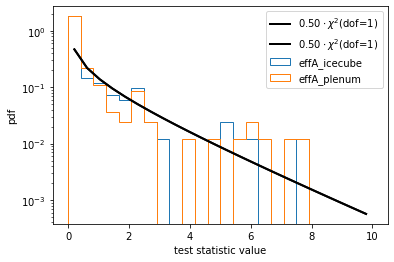

In [19]:
fig, ax = plt.subplots()

ts_bins = np.linspace(0,10,25)
for exp_key, trials in bckg_trials.items():
    ax.hist(trials['ts'], bins=ts_bins, histtype='step', label=exp_key, 
            density=True)
    
    eta = np.sum(trials['ts']==0) / float(len(trials))
    print(eta)
    xvals = get_mids(ts_bins)
    fit_func = delta_chi2(eta=0.5, df=1.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=1)')
    
ax.set_xlabel('test statistic value')
ax.set_ylabel('pdf')

ax.legend()
ax.set_yscale('log')


# Get the median expectation for signal

Do a llh scan using the meadian expectations first

In [20]:
norms = kra_ana._norms

lambda_b = kra_ana._generate_background_expectation(atm_keys=['numu_conv'], astro_bckg=True)
ls_norm = kra_ana._generate_signal_expectation(norm=1.)
scans = dict()
for k, lb in lambda_b.items():
    scans[k] = np.zeros_like(norms, dtype=float)
data = dict()
for key, lb in lambda_b.items():
    data[key] = (lb+ls_norm[key])
    
    
for i, normi in enumerate(norms):    
    lambda_s = kra_ana._generate_signal_expectation(norm=normi)
    
    for key, lb in lambda_b.items(): 
        d = data[key]
        for k, lbk in enumerate(lb):
            lbk[~spatial_masks[key]] = 0
        #    ls_norm[key][k][~spatial_masks[key]] = 0
            lambda_s[key][0,k][~spatial_masks[key]] = 0
        
        
        scans[key][i] = kra_ana._llh_ratio_function(d, lambda_b=lb, lambda_s=lambda_s[key][0])
    


0.9999999999999755
0.9999999999999755


(0.0, 30.0)

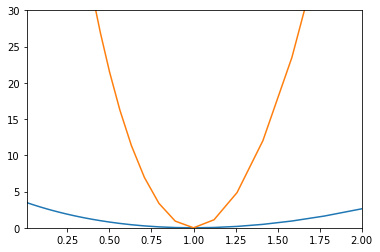

In [21]:
fig, ax = plt.subplots()
for key, scani in scans.items():
    ax.plot(norms, -1*(scani-scani.max()))
    print(norms[np.argmax(scani)])
ax.set_xlim(0.01,2)
ax.set_ylim(0,30)
#ax.set_xscale('log')
#ax.set_yscale('log')

In [31]:
normalisations = 10**np.linspace(-2,1,25)

lambda_b = kra_ana._generate_background_expectation(atm_keys=['numu_conv'], astro_bckg=True)
pbar = ProgressBar(len(normalisations),parent=None).start()

median_ts_scan = dict()
for exp_key, trials in bckg_trials.items():
    median_ts_scan[exp_key] = list()

for norm_sigi in normalisations:
    
    ls_norm = kra_ana._generate_signal_expectation(norm=norm_sigi)
    scans = dict()
    for k, lb in lambda_b.items():
        scans[k] = np.zeros_like(norms, dtype=float)
    data = dict()
    for key, lb in lambda_b.items():
        data[key] = (lb+ls_norm[key])
    
    for i, normi in enumerate(norms):    
        lambda_s = kra_ana._generate_signal_expectation(norm=normi)

        for key, lb in lambda_b.items(): 
            d = data[key]
            for k, lbk in enumerate(lb):
                lbk[~spatial_masks[key]] = 0
            #    ls_norm[key][k][~spatial_masks[key]] = 0
                lambda_s[key][0,k][~spatial_masks[key]] = 0


            scans[key][i] = kra_ana._llh_ratio_function(d, lambda_b=lb, lambda_s=lambda_s[key][0])
    
    for key, scani in scans.items():
        median_ts_scan[key].append(np.max(scani))
    
    pbar.increment()
pbar.finish()



    

[==========================================================] 100% ELT 0h:00m:17s


Now generate some trials to see if the code works as expected

In [22]:
inj_trials = kra_ana.do_trials(n_trials=1, signal_kwargs={'norm':1.},
                               bckg_kwargs = dict(atm_keys=['numu_conv'], astro_bckg=True),
                              spatial_masks=spatial_masks, med=True)

effA_icecube [3.54756973] 0.029816365144478343 0.9999999999999755
effA_plenum [107.86744019] 1.4368484810671944e-25 0.9999999999999755


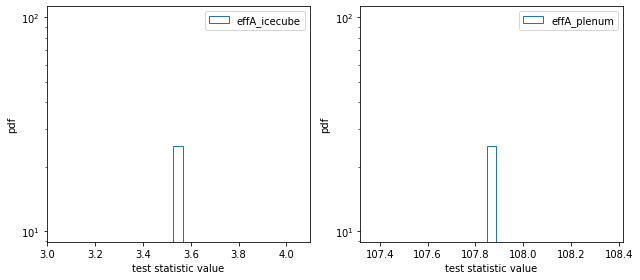

In [23]:
fig, axes = plt.subplots(ncols=2,figsize=(9,4))


for k, (exp_key, trials) in enumerate(inj_trials.items()):
    ax = axes[k]
    h,ts_bins, _= ax.hist(trials['ts'],bins=25, histtype='step', label=exp_key, 
            density=True)
    
    print(exp_key, trials['ts'], fit_func.sf(np.median(trials['ts'])), np.median(trials['norm']))
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('test statistic value')
    ax.set_ylabel('pdf')
    
fig.tight_layout()

effA_icecube 3.547569733420196 0.029816365144478343 0.9999999999999755
effA_plenum 107.86744019125753 1.4368484810671944e-25 0.9999999999999755


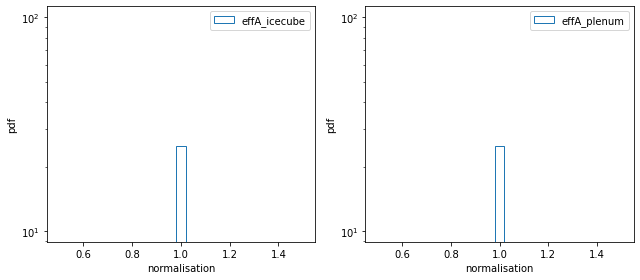

In [24]:
fig, axes = plt.subplots(ncols=2,figsize=(9,4))


for k, (exp_key, trials) in enumerate(inj_trials.items()):
    ax = axes[k]
    h,ts_bins, _= ax.hist(trials['norm'],bins=25, histtype='step', label=exp_key, 
            density=True)
    
    print(exp_key, np.median(trials['ts']), fit_func.sf(np.median(trials['ts'])), np.median(trials['norm']))
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('normalisation')
    ax.set_ylabel('pdf')
    
fig.tight_layout()

# Now check which normalisations we might be able to detect

In [25]:

Res = dict()
pbar = ProgressBar(len(normalisations),parent=None).start()
for normi in normalisations:
    Res[normi] = kra_ana.do_trials(n_trials=250, signal_kwargs={'norm':normi},
                               bckg_kwargs = dict(atm_keys=['numu_conv'], astro_bckg=True),
                              spatial_masks=spatial_masks)
    
    pbar.increment()
pbar.finish()

[==========================================================] 100% ELT 0h:20m:06s


In [26]:
median_ts = dict()
for exp_key, trials in bckg_trials.items():
    median_ts[exp_key] = list()
for normi, res in Res.items():
    for k, (key,triali) in enumerate(res.items()):
        median_ts[key].append(np.median(triali['ts']))
    
    

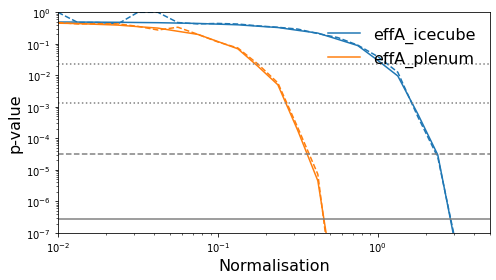

In [33]:
fs=16
fig, ax = plt.subplots( figsize=(7,4.))


for key, med in median_ts.items():
    
    p=ax.plot(normalisations, fit_func.sf(med), ls='dashed')
    ax.plot(normalisations, fit_func.sf(median_ts_scan[key]), 
            ls='solid', label=key, color=p[0].get_color())
    
ax.axhline(sigma2pval(2), color='grey', ls='dotted')
ax.axhline(sigma2pval(3), color='grey', ls='dotted')
ax.axhline(sigma2pval(4), color='grey', ls='dashed')
ax.axhline(sigma2pval(5), color='grey', ls='solid')
    
ax.legend(fontsize=fs, loc='upper right', frameon=False)
ax.set_yscale('log')

ax.set_ylim(1e-7,1)
ax.set_xlim(1e-2,5)
ax.set_xscale('log')
ax.set_xlabel(r'Normalisation', fontsize=fs)
ax.set_ylabel('p-value', fontsize=fs)

fig.tight_layout()

In [30]:
from scipy.stats import norm as norm_func
norm_func.sf(2.)

0.022750131948179195

In [29]:
fit_func.sf(2.6)

0.053431857496689564